# Linear Regression - Top model according to the SCPM of -4.75	(dominance count 19)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

# Feature importance
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "206",
    "Plant": "B",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/206/b.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [9]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

## 1.3. Time Series Cross Validation

In [10]:
repeats = 1
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 1
n_splits: 5

******
[TRAIN]
******
RMSE: -1.142 (0.027)
MAE: -0.907 (0.018)
MAPE: -0.020 (0.001)
R2: 0.852 (0.024)


******
[TEST]
******
RMSE: -1.387 (0.235)
MAE: -1.073 (0.152)
MAPE: -0.024 (0.004)
R2: 0.717 (0.053)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    # index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    # index_preds = np.concatenate([index_train, index_test])
    index_preds = index_test

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    # df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
199,2020-07-11,48.1550,48.186896,TEST
200,2020-07-11,40.0825,41.212819,TEST
201,2020-07-13,43.4750,41.671032,TEST
202,2020-07-14,47.7475,47.507282,TEST
203,2020-07-14,41.5675,42.117128,TEST
...,...,...,...,...
1164,2023-02-22,39.4950,41.981871,TEST
1165,2023-02-23,41.3350,42.087078,TEST
1166,2023-02-25,45.6275,43.038835,TEST
1167,2023-02-28,40.4175,41.888027,TEST


<IPython.core.display.Javascript object>

In [13]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
# df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

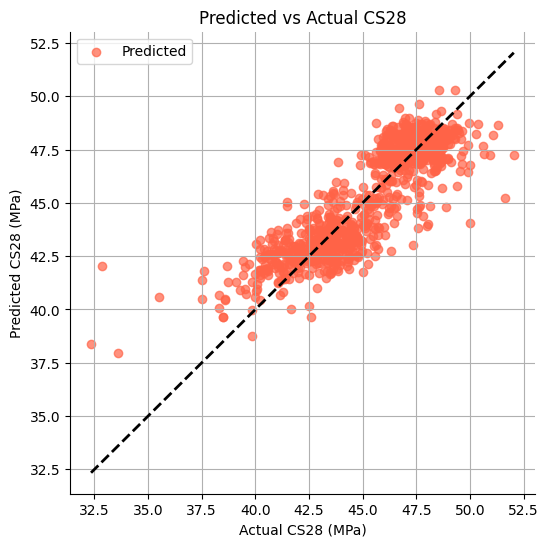

<IPython.core.display.Javascript object>

In [15]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_206_b_local_cm_p_cs_tiss_top_scpm_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
df["Cement_Type"].value_counts()

Cement_Type
CPVARI      598
CPIV32RS    571
Name: count, dtype: int64

<IPython.core.display.Javascript object>

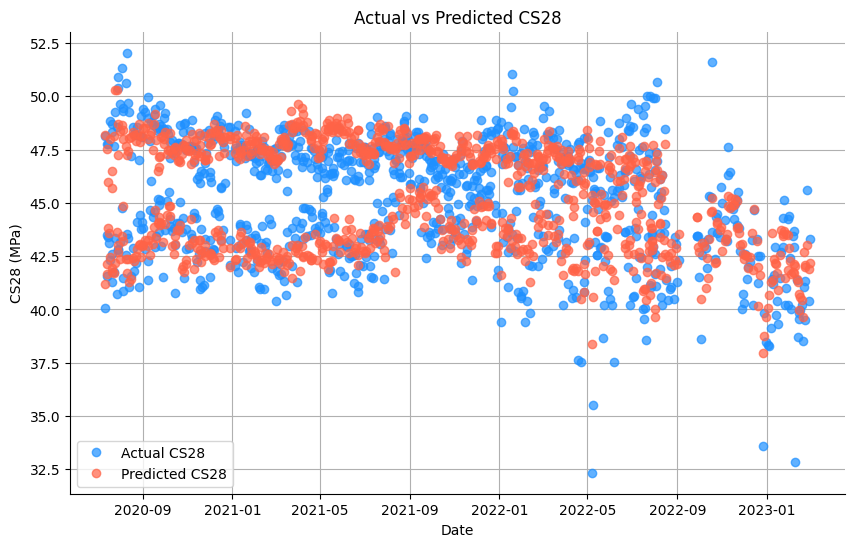

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_206_b_local_cm_p_cs_tiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [18]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [19]:
df_importances

,MgO,SO3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Coefficients - 0,0.178120,-0.215513,-0.727507,-1.178105,0.511825,-0.087619,-0.571602,0.027311,-0.114390,-1.116951,1.576098,0.754682
Coefficients - 1,0.097923,-0.157692,-0.584770,-0.799863,0.250724,-0.198353,0.037680,0.040913,-0.049756,-0.090866,0.961809,0.944501
Coefficients - 2,0.378491,-0.027598,-0.437846,-0.456570,-0.114622,-0.431078,0.420348,0.052078,-0.036398,-0.139538,0.767445,0.908967
Coefficients - 3,0.360232,0.001807,-0.415434,-0.395684,-0.251669,-0.190431,0.421553,0.086627,-0.020829,-0.098994,0.778477,0.897037
Coefficients - 4,0.369077,0.028915,-0.232621,-0.411773,-0.125694,0.114710,-0.090147,0.045419,0.013763,-0.266250,0.788361,1.156807


<IPython.core.display.Javascript object>

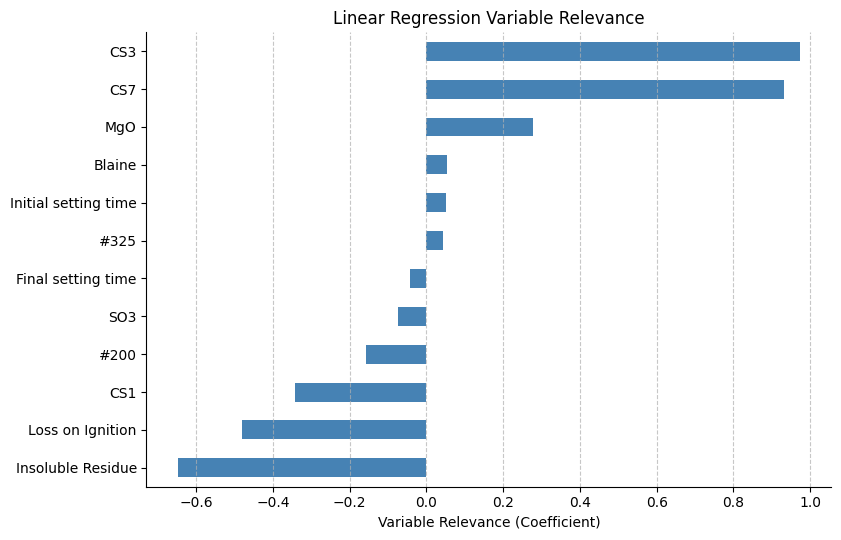

<IPython.core.display.Javascript object>

In [20]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Relevance")
plt.xlabel("Variable Relevance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

In [21]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

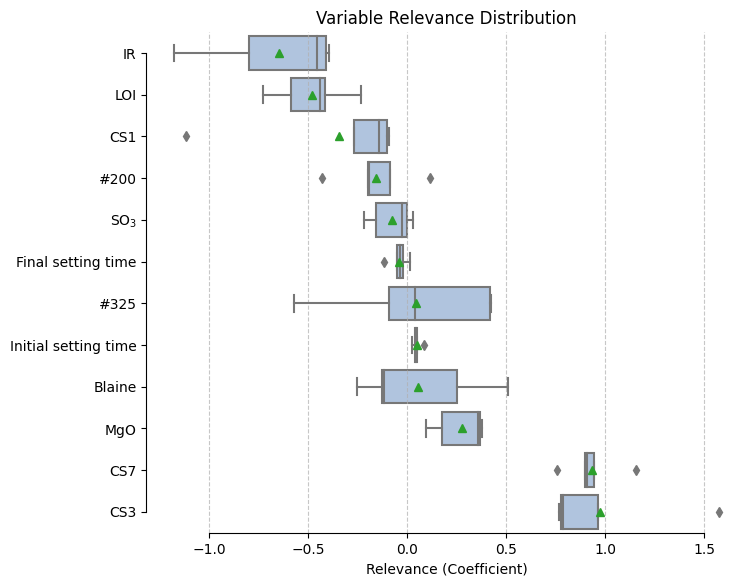

<IPython.core.display.Javascript object>

In [22]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_206_b_local_cm_p_cs_tiss_top_scpm_dist_var_coef_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [23]:
df_importances

,MgO,SO3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Coefficients - 0,0.178120,-0.215513,-0.727507,-1.178105,0.511825,-0.087619,-0.571602,0.027311,-0.114390,-1.116951,1.576098,0.754682
Coefficients - 1,0.097923,-0.157692,-0.584770,-0.799863,0.250724,-0.198353,0.037680,0.040913,-0.049756,-0.090866,0.961809,0.944501
Coefficients - 2,0.378491,-0.027598,-0.437846,-0.456570,-0.114622,-0.431078,0.420348,0.052078,-0.036398,-0.139538,0.767445,0.908967
Coefficients - 3,0.360232,0.001807,-0.415434,-0.395684,-0.251669,-0.190431,0.421553,0.086627,-0.020829,-0.098994,0.778477,0.897037
Coefficients - 4,0.369077,0.028915,-0.232621,-0.411773,-0.125694,0.114710,-0.090147,0.045419,0.013763,-0.266250,0.788361,1.156807


<IPython.core.display.Javascript object>

In [24]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
Insoluble Residue,5.0,-0.648399,0.339185,-1.178105,-0.799863,-0.456570,-0.411773,-0.395684
Loss on Ignition,5.0,-0.479636,0.186667,-0.727507,-0.584770,-0.437846,-0.415434,-0.232621
CS1,5.0,-0.342520,0.438576,-1.116951,-0.266250,-0.139538,-0.098994,-0.090866
#200,5.0,-0.158554,0.197847,-0.431078,-0.198353,-0.190431,-0.087619,0.114710
SO3,5.0,-0.074016,0.106679,-0.215513,-0.157692,-0.027598,0.001807,0.028915
Final setting time,5.0,-0.041522,0.047139,-0.114390,-0.049756,-0.036398,-0.020829,0.013763
#325,5.0,0.043566,0.412669,-0.571602,-0.090147,0.037680,0.420348,0.421553
Initial setting time,5.0,0.050470,0.022153,0.027311,0.040913,0.045419,0.052078,0.086627
Blaine,5.0,0.054113,0.317199,-0.251669,-0.125694,-0.114622,0.250724,0.511825
MgO,5.0,0.276769,0.129954,0.097923,0.178120,0.360232,0.369077,0.378491


<IPython.core.display.Javascript object>

In [25]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [26]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

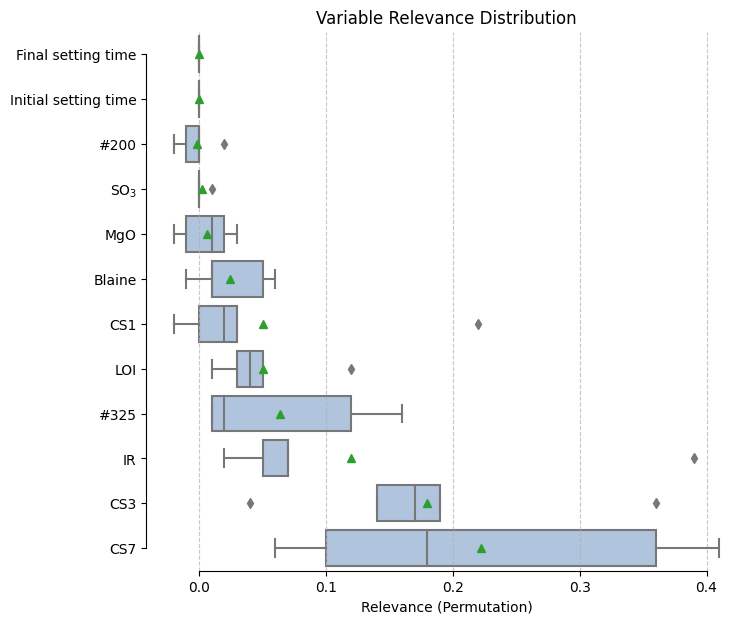

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_206_b_local_cm_p_cs_tiss_top_scpm_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [28]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Final setting time,5.0,-0.0010,0.0016,-0.0033,-0.0014,-0.0008,-0.0006,0.0011
Initial setting time,5.0,-0.0006,0.0022,-0.0030,-0.0021,-0.0008,0.0008,0.0023
#200,5.0,0.0004,0.0145,-0.0193,-0.0071,0.0043,0.0045,0.0195
SO3,5.0,0.0030,0.0033,0.0001,0.0010,0.0012,0.0044,0.0081
MgO,5.0,0.0084,0.0203,-0.0179,-0.0068,0.0123,0.0247,0.0297
Blaine,5.0,0.0227,0.0273,-0.0069,0.0084,0.0091,0.0471,0.0560
CS1,5.0,0.0490,0.0973,-0.0182,-0.0047,0.0221,0.0261,0.2200
LOI,5.0,0.0526,0.0412,0.0133,0.0311,0.0438,0.0535,0.1212
#325,5.0,0.0628,0.0707,0.0082,0.0113,0.0165,0.1208,0.1570
Insoluble Residue,5.0,0.1198,0.1528,0.0176,0.0497,0.0666,0.0747,0.3904


<IPython.core.display.Javascript object>

In [29]:
perm_importances_df

,Final setting time,Initial setting time,#200,SO3,MgO,Blaine,CS1,LOI,#325,Insoluble Residue,CS3,CS7
0,-0.000649,0.000775,0.004252,0.001047,0.012267,0.056028,0.219966,0.121193,0.120812,0.390375,0.360545,0.102721
1,-0.003299,-0.000788,-0.019253,0.008091,-0.006759,0.047079,0.022060,0.013344,0.008211,0.074745,0.142907,0.056370
2,-0.001352,0.002322,0.004469,0.001153,-0.017860,-0.006895,0.026102,0.053488,0.156987,0.017563,0.040663,0.175161
3,0.001094,-0.002992,0.019525,0.000136,0.029734,0.009110,-0.004723,0.043786,0.016510,0.049742,0.188235,0.360830
4,-0.000792,-0.002139,-0.007139,0.004401,0.024694,0.008383,-0.018218,0.031118,0.011330,0.066571,0.165810,0.406032


<IPython.core.display.Javascript object>